In [108]:
# Database used: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data
# TODO Maybe we should not be using pictures of glaciers, mountains, etc., just one single type of image
#  (for now)

import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [109]:
train_set = {'buildings': [],
           'forest': [],
           'glacier': [],
           'mountain': [],
           'sea': [],
           'street': []
          }
test_set = {'buildings': [],
           'forest': [],
           'glacier': [],
           'mountain': [],
           'sea': [],
           'street': []
          }
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [110]:
DATASET_PATH = "../dataset"

In [111]:
def go_though_database(database_path):
    for path, subdirs, files in os.walk(database_path):
        for file in files:
            #print(path)
            current_path = path
            if 'seg_train/seg_train' in path:
                file_path = os.path.join(path, file)
                for category in categories:
                    if category in file_path:
                        train_set[category].append(file_path)
            if 'seg_test/seg_test' in path:
                file_path = os.path.join(path, file)
                for category in categories:
                    if category in file_path:
                        test_set[category].append(file_path)

In [112]:
go_though_database(DATASET_PATH)

In [113]:
def create_mask(image):
    img_height, img_width = image.shape[:2] #(150, 150, 3)
    mask = 255 * np.ones_like(image) # matrix of ones -> white image
    blackout_start_index = img_width // 3
    
    for i in range(img_height):
        for j in range(img_width):
            if j >= blackout_start_index and j < 2*blackout_start_index:
                mask[i, j] = 0

    return mask

In [114]:
# applys mask to the image 
def edit_image(image_path):
    image = cv2.imread(image_path)
    mask = create_mask(image)
    edited_image = cv2.bitwise_and(image, mask)
    return edited_image


In [115]:
def save_edited_images(image_paths, category, set_type):
    directory = f"../dataset/edited/{set_type}/{category}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    for index, image_path in enumerate(image_paths):
        image = edit_image(image_path)
        edited_image_name = image_path.split('/')[-1].split('.')[0] + '_edited.jpg'
        edited_image_path = os.path.join(directory, edited_image_name)
        # (input_image_path, output_image_path)
        image_paths[index] = (edited_image_path, image_path)
        cv2.imwrite(edited_image_path, image)
        

In [116]:
for category in categories:
    save_edited_images(train_set[category], category, "train")
    save_edited_images(test_set[category], category, "test")

In [127]:
MAX_PIXEL_COLOR_VALUE = 255.0

In [128]:
def load(image_path):
    input_image_path, output_image_path = image_path
    input_image = tf.io.read_file(input_image_path)
    input_image = tf.io.decode_jpeg(input_image)
    input_image = tf.cast(input_image, tf.float32)
    output_image = tf.io.read_file(output_image_path)
    output_image = tf.io.decode_jpeg(output_image)
    # TODO [vukan] : Why is this needed? (Check with Kaca)
    output_image = tf.cast(output_image, tf.float32)
    return input_image, output_image

In [129]:
train_set['buildings'][-1]

('../dataset/edited/train/buildings/19608_edited.jpg',
 '../dataset/seg_train/seg_train/buildings/19608.jpg')

(150, 150, 3)
(150, 150, 3)


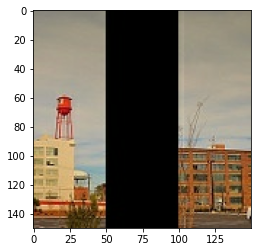

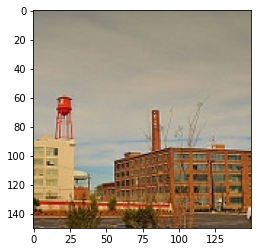

In [130]:
input_image, output_image = load(train_set['buildings'][-1])
print(input_image.shape)
print(output_image.shape)
plt.figure()
plt.imshow(input_image / MAX_PIXEL_COLOR_VALUE)
plt.figure()
plt.imshow(output_image / MAX_PIXEL_COLOR_VALUE)

In [131]:
def normalize_images(input_image, output_image) :
    input_image = (input_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1 
    output_image = (output_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1  
    return input_image, output_image

In [ ]:
# TODO [vukan] : Check with Kaca, are we adding the resizing and jittering?